In [69]:
import numpy as np
import csv
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torchvision

In [70]:
from sklearn.model_selection import train_test_split
 #首先，读取.CSV文件成矩阵的形式。
my_matrix = np.loadtxt(open("results.csv"),delimiter=",",skiprows=0)
#print(my_matrix)
 #对于矩阵而言，将矩阵倒数第一列之前的数值给了X（输入数据），将矩阵大最后一列的数值给了y（标签）
X, y = my_matrix[:,:-1],my_matrix[:,-1]
 #利用train_test_split方法，将X,y随机划分问，训练集（X_train），训练集标签（X_test），测试卷（y_train），
 #测试集标签（y_test），安训练集：测试集=7:3的
 #概率划分，到此步骤，可以直接对数据进行处理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 #此步骤，是为了将训练集与数据集的数据分别保存为CSV文件
 #np.column_stack将两个矩阵进行组合连接
train= np.column_stack((X_train,y_train))
 #numpy.savetxt 将txt文件保存为.csv结尾的文件
np.savetxt('train_usual.csv',train, delimiter = ',')
test = np.column_stack((X_test, y_test))
np.savetxt('test_usual.csv', test, delimiter = ',')

In [71]:
torch_x = torch.from_numpy(X_train)
torch_y = torch.from_numpy(y_train)
test_x = torch.from_numpy(X_test)
test_y = torch.from_numpy(y_test)
y_train = torch.tensor(torch_y, dtype=torch.long)
y_test = torch.tensor(test_y,dtype = torch.long)
x_test = torch.tensor(test_x , dtype=torch.float32)
x_train = torch.tensor(torch_x, dtype=torch.float32)


#x_train = torch.tensor(torch_x, dtype=torch.float32)

#y_train = torch_y.reshape(torch_y.shape[0], 1)
#x,y = Variable(x_train),Variable(y_train)


/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [72]:
print(x_train.shape, x_test.shape)

torch.Size([797, 1200]) torch.Size([342, 1200])


In [127]:
#Hyper parameters
EPOCH = 20
BATCH_SIZE = 50
LR = 0.001


In [128]:
x_test = x_test.reshape(x_test.shape[0], 20,60)
x_train = x_train.reshape(x_train.shape[0], 20,60)
torch_dataset = Data.TensorDataset(x_train,y_train )
train_loader = Data.DataLoader(dataset= torch_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)


In [129]:
#print(x_train, x_test)

In [130]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv1d(
                in_channels=20,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                                            # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool1d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv1d(16, 32, 5, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool1d(2),                # output shape (32, 7, 7)
        )

        self.out = nn.Linear(32 * 12, 8)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [131]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr = LR)
loss_func = torch.nn.CrossEntropyLoss()

In [132]:
Loss_CNN = []
Times = []
times = 0
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        Loss_CNN.append(loss.data)
        times += 1
        Times.append(times)
        #print(times)

        if step % 50 == 0:
            train_output, last_layer = cnn(x_train)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == y_train).sum().item() / float(y_train.size(0))
            print('epoch:'+ str(epoch) + 'loss:'+ str(loss)+'|train accuracy:' + str(accuracy) )



            
            
            
            
    

epoch:0loss:tensor(2.0811, grad_fn=<NllLossBackward>)|train accuracy:0.1191969887076537
epoch:1loss:tensor(2.0420, grad_fn=<NllLossBackward>)|train accuracy:0.31493099121706397
epoch:2loss:tensor(1.9720, grad_fn=<NllLossBackward>)|train accuracy:0.4755332496863237
epoch:3loss:tensor(1.7647, grad_fn=<NllLossBackward>)|train accuracy:0.5056461731493099
epoch:4loss:tensor(1.3467, grad_fn=<NllLossBackward>)|train accuracy:0.6386449184441656
epoch:5loss:tensor(1.1566, grad_fn=<NllLossBackward>)|train accuracy:0.7164366373902133
epoch:6loss:tensor(0.9539, grad_fn=<NllLossBackward>)|train accuracy:0.7754077791718946
epoch:7loss:tensor(0.5809, grad_fn=<NllLossBackward>)|train accuracy:0.7741530740276035
epoch:8loss:tensor(0.4970, grad_fn=<NllLossBackward>)|train accuracy:0.8343789209535759
epoch:9loss:tensor(0.2458, grad_fn=<NllLossBackward>)|train accuracy:0.8670012547051443
epoch:10loss:tensor(0.4089, grad_fn=<NllLossBackward>)|train accuracy:0.8895859473023839
epoch:11loss:tensor(0.3142, gr

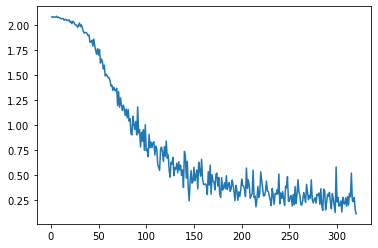

In [136]:
#print(Times)
#print()
plt.plot(Times,Loss_CNN)
plt.show()
np.save('Loss_CNN.npy',Loss_CNN)

In [134]:
test_output, last_layer = cnn(x_test)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = (pred_y == y_test).sum().item() / float(test_y.size(0))
print('| test accuracy: %.2f' % accuracy)

| test accuracy: 0.92


In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

In [100]:
#print(pred_y.numpy(),y_test)

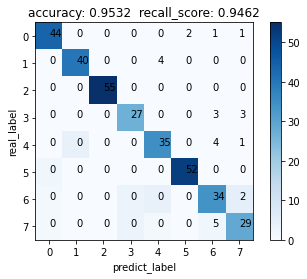

In [137]:
# 预测数据，predict之后的预测结果集
guess = pred_y.numpy()
# 真实结果集
fact = y_test.numpy()
# 类别
classes = list(set(fact))
# 排序，准确对上分类结果
classes.sort()
# 对比，得到混淆矩阵
confusion = confusion_matrix(guess, fact)
# 热度图，后面是指定的颜色块，gray也可以，gray_x反色也可以
plt.imshow(confusion, cmap=plt.cm.Blues)
# 这个东西就要注意了
# ticks 这个是坐标轴上的坐标点
# label 这个是坐标轴的注释说明
indices = range(len(confusion))
# 坐标位置放入
# 第一个是迭代对象，表示坐标的顺序
# 第二个是坐标显示的数值的数组，第一个表示的其实就是坐标显示数字数组的index，但是记住必须是迭代对象
plt.xticks(indices, classes)
plt.yticks(indices, classes)
# 热度显示仪？就是旁边的那个验孕棒啦
plt.colorbar()
# 就是坐标轴含义说明了
plt.xlabel('predict_label')
plt.ylabel('real_label')
# 显示数据，直观些
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.title('accuracy: 0.9532  recall_score: 0.9462')
plt.savefig('CNN_results.tif', dpi = 400)
plt.show()


In [102]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
print(accuracy_score(fact,guess),recall_score(fact, guess,average='macro'))

0.9532163742690059 0.9462808229352347
